# Assignment 3 - Partial Differential Equations

In this assignment, you will find numerical solutions to partial differential equations.  In particular, you will use an implicit method for solving the diffusion equation, considering problems with both Dirichlet and Neumann boundary conditions.

In each part of this assignment, you will be asked to write some code in the cell indicated.  If you find it convenient to break your code up over multiple cells, please do so.  You will also be asked to discuss your code and results obtained in a text cell.

You should use numpy and scipy libraries where appropriate. You will always be told explicitly if you should **not** use a particular library.  Make sure to comment your code.  Make sure all cells run from a freshly started notebook before you submit your work.

## The Diffusion Equation

In this assignment, you will find numerical solutions to the diffusion equation.

$$\frac{\partial u}{\partial t} = k\frac{\partial^2 u}{\partial x^2}$$

You should discretize this equation onto $N_x$ space points, with separation $\Delta x = h$, and into timesteps $\Delta t = \tau$.  In the equations below, I use subscript $i$ as a space index, and superscript $n$ for time indices.

Having discretized the problem, you should use the _implicit_ finite difference equation, as discussed in lectures :

$$\frac{u_i^{n+1} - u_i^n}{\tau} = k \frac{u_{i+1}^{n+1} - 2u_i^{n+1} + u_{i-1}^{n+1}}{h^2}$$

This can be written in matrix form $u^n = M u^{n+1}$ using :

$$u_i^n = - \alpha u_{i-1}^{n+1} + (1 + 2\alpha) u_i^{n+1} - \alpha u_{i+1}^{n+1}$$

where $\alpha = \frac{k \tau}{h^2}$.

In the problems below, you are asked to solve the diffusion equation in the context of the heat equation. Here, $k$ is the thermal diffusivity, given by $k = \frac{\lambda}{\rho C}$, where $\lambda$ is the thermal conductivity, $\rho$ is the density, and $C$ is the specific heat capacity. The questions below concern an iron poker of length 50cm.  You may take the thermal conductivity of iron to be a constant 59 W/m/K, its specific heat as 450 J/kg/K, and its density as 7,900 kg/m3.  You can ignore heat loss along the length of the poker.


## Part 1 - Dirichlet Boundary Conditions

The poker is initially in equilibrium, at room temperature of 20 C. At time $t = 0$, one end is thrust into a furnace at 1000 C and the other end is held in an ice bath at 0 C. Your task is to calculate the temperature distribution along the poker as a function of time.

The fact that the ends of the rod are held at fixed temperatures of 0 C and 1000 C corresponds to a Dirichlet boundary condition.  These can be included in the implicit method as follows.

The implicit finite difference equation, above, will allow us to calculate the unknown 'internal' nodes, ie. $0 < i < (N_x-1)$.  However, the boundary nodes, $i=0, N_x$, must have fixed values $d_0, d_N$.  To fix the boundaries, we take the matrix M to be of size $(N_x-2) \times (N_x-2)$, and adding a vector term :

$$u^n = Mu^{n+1} + b$$

For $N_x = 7$ (for example), this gives :

$$M = \pmatrix{
1+2\alpha & -\alpha   &           &           &           & \\
-\alpha   & 1+2\alpha & -\alpha   &           &           & \\
          & -\alpha   & 1+2\alpha & -\alpha   &           & \\
          &           & -\alpha   & 1+2\alpha & -\alpha   & \\
          &           &           & -\alpha   & 1+2\alpha & \\
}$$

$$b = \pmatrix{
-\alpha d_0 \\
0 \\
0 \\
0 \\
-\alpha d_N \\
}$$

You can show this gives the required finite equation for $i=1, (N-1)$, eg. :

$$u^n_1 = - \alpha u^{n+1}_2 + (1 + 2\alpha)u^{n+1}_1 - \alpha d_0$$

Your code should construct the matrix equation including boundary value term, and solve it using an appropriate linear algebra routine from scipy. You should verify your results, and quantify the uncertainties due to the method.  Discuss your results in the cell below.

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as linalg

class LaplaceSolverGrid:
    """Grids for solving the Laplace equation with Dirichlet boundary conditions"""
    
    def setup(self, n_x):
        """Initialise internal variables"""
        
        #1D grid for SOR method
        self.v0 = np.zeros((n_x,1))
        
        #Fixed nodes (Dirichlet boundaries) 
        self.isDirichlet = np.zeros((n_x,1), dtype=bool)
        
        #Values of Dicirhlet nodes
        self.dirichletValue = np.zeros((n_x,1))
                
    def setDirichletNode(self, i, v):
        """Set a given node to a boundary value"""
        self.isDirichlet[i][0] = True
        self.dirichletValue[i][0] = v

    def initRandom(self, vmin, vmax):
        """Initialise each node to a random value in given range"""
        
        rnd = vmin + (vmax-vmin)*np.random.rand(self.v0.shape[0], self.v0.shape[1])
        self.v0 = np.where(self.isDirichlet, self.dirichletValue, rnd)
    
    def setup_values(self, tau):
        """Setup for the values of the rod"""
        #Parameters
        lambd = 59
        rho = 7900
        C = 450
        L = 50
        
        #x spacing
        n_x = self.v0.shape[0]
        h = L/n_x

        self.alpha = (tau*lambd)/(rho*C*h**2)
        
        #matrix setup M
        self.M = np.zeros((n_x-2,n_x-2))
        for i in range(n_x-2):
            for j in range(n_x-2):
                if i == j:
                    self.M[i][j] = 1 + 2*self.alpha
                elif i == j+1 or i == j-1:
                    self.M[i][j] = -1*self.alpha
        
        #matrix setup b
        self.b = np.zeros((n_x-2,1))
        d_0 = self.v0[0][0]
        d_N = self.v0[n_x-1][0]
        self.b[0] = -self.alpha*d_0
        self.b[n_x-3] = -self.alpha*d_N
    
    def ifd(self):
        """Apply the imlicit finite difference method equation"""
        #v(t+1) = M^-1@(v(t)-b)
        
        return linalg.inv(self.M) @ (self.v0[1:self.v0.shape[0]-1,:] -self.b)

In [13]:
def runSOR(grid, omega, atol, timestep, tmin, tmax):
    """Implement successive-over-relaxation"""
    
    results = grid.v0
    final = grid.v0
    
    #This loop just keeps track of the iteration number t
    for t in range(tmax) :

        dmax = 0.
        u = grid.ifd()
        
        #This loop goes over every node in v0 then updates it
        for i in range(grid.v0.shape[0]):
            
            # do not update Dirichlet nodes
            if grid.isDirichlet[i]:
                grid.v0[i] = grid.dirichletValue[i]
            
            else:
                old = grid.v0[i]
                new = u[i-1]
                d = new - old
                
                if abs(d) > dmax:
                        dmax=abs(d)
                        
                grid.v0[i] = old+omega*d
        
        #If t is factor of timestep saves v0 for graph
        if (t/timestep).is_integer() == True:
            results = np.append(results, grid.v0, axis=1)
            
        # test for convergence
        if t>tmin and dmax<atol:
            final = grid.v0
            return results
        
    return results

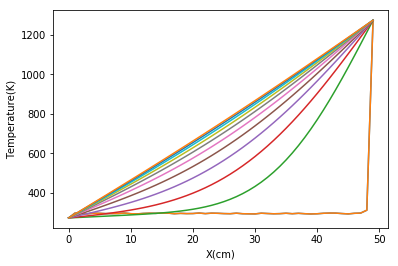

In [14]:
#Setup 1d rod
grid1 = LaplaceSolverGrid()
grid1.setup(50)
#Boundary Conditions
grid1.setDirichletNode(0,273)
grid1.setDirichletNode(49,1273)

#Starting conditions
grid1.initRandom(293, 298)

grid1.setup_values(1)

#Timestep
t_step = 5000
#run sor
result = runSOR(grid1, omega=1000, atol=0.000001, timestep=t_step, tmin=1000, tmax=100000)

plt.plot(np.arange(50),result)

plt.xlabel('X(cm)')
plt.ylabel('Temperature(K)')
plt.show()

**Use this cell to discuss your code & results**

The class laplace solver grid is mostly taken from the Relaxation Methods jupyter notebook. Setup sets up the 1D metal rod array self.v0 which I have set to 50 indicies which each correspond to 1cm intervals along the rod. SetDirichletNode sets the dirichlet boundary conditions and their values. Initrandom sets all other nodes to random values between vmin and vmax which I have set to 20 and 25 degrees celcius. Setup_values contains the metal parameters for the rod as well as tau which is the timestep, which I have set to 1 second. These are used to alpha which is then used in the matrices M and b that are used in the inplicit finite difference equation.

As shown in the graph as time increases the heat spreads along the bar as expected until it reaches a final state with a linear relationship between the x value and temperature.

## Part 2 - Neumann Boundary Conditions

Now we assume the far end of the poker from the furnace is no longer held at 0 C, but instead experiences no heat loss. Again your task is to find the tempeterature distribution as a function of time.

In this case, you will need to implement a Neumann boundary condition at the end of the poker, to ensure the derivative $\frac{\partial u}{\partial x}$ is zero. Since we are using finite differences, this is equivalent to ensuring the final two nodes have the same value.

The finite difference equation for node $i=(N-1)$ is :

$$u^n_{N-1} = -\alpha u^{n+1}_{N-2} + (1 + 2\alpha)u^{n+1}_{N-1} - \alpha u^{n+1}_{N}$$

To enforce the Neumann boundary condition we can substitute $u^{n+1}_{N} = u^{n+1}_{N-1}$, giving :

$$u^n_{N-1} = -\alpha u^{n+1}_{N-2} + (1 + \alpha)u^{n+1}_{N-1}$$

This results in a modified form of $M$, shown here for the example $N_x=7$, and the matrix ix $5\times5$ :  

$$M = \pmatrix{
1+2\alpha & -\alpha   &           &           &           & \\
-\alpha   & 1+2\alpha & -\alpha   &           &           & \\
          & -\alpha   & 1+2\alpha & -\alpha   &           & \\
          &           & -\alpha   & 1+2\alpha & -\alpha   & \\
          &           &           & -\alpha   & 1+\alpha & \\
}$$

Note that you will also need to include a boundary term vector $b$, since the end of the poker in the furnace still requires a Dirichlet condition.

In [15]:
class NeumannSolverGrid:
    """Grids for solving the Laplace equation with Neumann boundary conditions"""
    
    def setup(self, n_x):
        """Initialise internal variables"""
        
        #1D grid for SOR method
        self.v0 = np.zeros((n_x,1))
        
        #Fixed nodes (Dirichlet boundaries) 
        self.isDirichlet = np.zeros((n_x,1), dtype=bool)
        
        #Values of Dicirhlet nodes
        self.dirichletValue = np.zeros((n_x,1))
                
    def setDirichletNode(self, i, v):
        """Set a given node to a boundary value"""
        self.isDirichlet[i][0] = True
        self.dirichletValue[i][0] = v

    def initRandom(self, vmin, vmax):
        """Initialise each node to a random value in given range"""
        
        rnd = vmin + (vmax-vmin)*np.random.rand(self.v0.shape[0], self.v0.shape[1])
        self.v0 = np.where(self.isDirichlet, self.dirichletValue, rnd)
    
    def setup_values(self, tau):
        """Setup for the values of the rod"""
        #Parameters
        lambd = 59
        rho = 7900
        C = 450
        L = 50
        
        #x spacing
        n_x = self.v0.shape[0]
        h = L/n_x

        self.alpha = (tau*lambd)/(rho*C*h**2)
        
        #matrix setup M
        self.M = np.zeros((n_x-1,n_x-1))
        for i in range(n_x-1):
            for j in range(n_x-1):
                if i == j:
                    if i == 0:
                        self.M[i][j] = 1 + self.alpha
                    else:
                        self.M[i][j] = 1 + 2*self.alpha
                elif i == j+1 or i == j-1:
                    self.M[i][j] = -1*self.alpha
        
        #matrix setup b
        self.b = np.zeros((n_x-1,1))
        d_N = self.v0[n_x-1][0]
        self.b[n_x-2] = -self.alpha*d_N
    
    def ifd(self):
        """Apply the imlicit finite difference method equation"""
        #v(t+1) = M^-1@(v(t)-b)
        
        return linalg.inv(self.M) @ (self.v0[0:self.v0.shape[0]-1,:] -self.b)

In [16]:
def runSOR_neumann(grid, omega, atol, timestep, tmin, tmax): 
    """Implement successive-over-relaxation with neumann conditions"""
    
    result = grid.v0
    
    #This loop just keeps track of the iteration number t
    for t in range(tmax+1) :

        dmax = 0.
        u = grid.ifd()
        
        #This loop goes over every node in v0 then updates it
        for i in range(grid.v0.shape[0]):
            
            # do not update Dirichlet nodes
            if grid.isDirichlet[i]:
                grid.v0[i] = grid.dirichletValue[i]
            
            else:
                old = grid.v0[i]
                new = u[i]
                d = new - old
                
                if abs(d) > dmax:
                        dmax=abs(d)
                        
                grid.v0[i] = old+omega*d
        
        #If t is factor of timestep saves v0 for graph
        if (t/timestep).is_integer() == True:
            result = np.append(result, grid.v0, axis=1)
            
        # test for convergence
        if t>tmin and dmax<atol:
            final = grid.v0
            return result
        
    return result

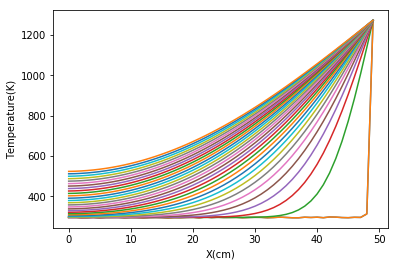

In [17]:
#Setup 1d rod
grid2 = NeumannSolverGrid()
grid2.setup(50)
#Boundary Conditions
grid2.setDirichletNode(49,1273)

#Starting conditions
grid2.initRandom(293, 298)

grid2.setup_values(1)

result = runSOR_neumann(grid2, omega=1000, atol=0.000001, timestep=1000, tmin=3000, tmax=30000)

plt.plot(np.arange(50),result)
plt.xlabel('X(cm)')
plt.ylabel('Temperature(K)')
plt.show()

**Use this cell to discuss your code & results**

The setup in this part is almost the same as that in part 1. Except with a different value in the M matrix which has a value of 1+alpha in the top-left due to the Neumann condtion that the end of the rod at 0 degrees experiences no heat loss. Also the M matrix must be (N_x-1)X(N_x-1) and b will have N_x-1 values as there is only 1 dirichlet condition this time at the end of rod in the furnace. 

As shown in this graph as time increases the heat spreads along the rod. However this time as x=0 is no longer held at zero degrees the temperature will increase. This fits what we expect as a result of the neumann boundary condition as no heat will be lost so the temperature of the whole metal bar will just keep on increasing.